Model: LogisticRegression
Accuracy: 0.862
Precision: 0.84
Recall: 0.988
F1 Score: 0.908
ROC-AUC: 0.851
              precision    recall  f1-score   support

       False       0.96      0.58      0.72        38
        True       0.84      0.99      0.91        85

    accuracy                           0.86       123
   macro avg       0.90      0.78      0.81       123
weighted avg       0.88      0.86      0.85       123

Confusion Matrix:
 [[22 16]
 [ 1 84]]
--------------------------------------------------
Model: DecisionTreeClassifier
Accuracy: 0.854
Precision: 0.832
Recall: 0.988
F1 Score: 0.903
ROC-AUC: 0.771
              precision    recall  f1-score   support

       False       0.95      0.55      0.70        38
        True       0.83      0.99      0.90        85

    accuracy                           0.85       123
   macro avg       0.89      0.77      0.80       123
weighted avg       0.87      0.85      0.84       123

Confusion Matrix:
 [[21 17]
 [ 1 84]]
--------

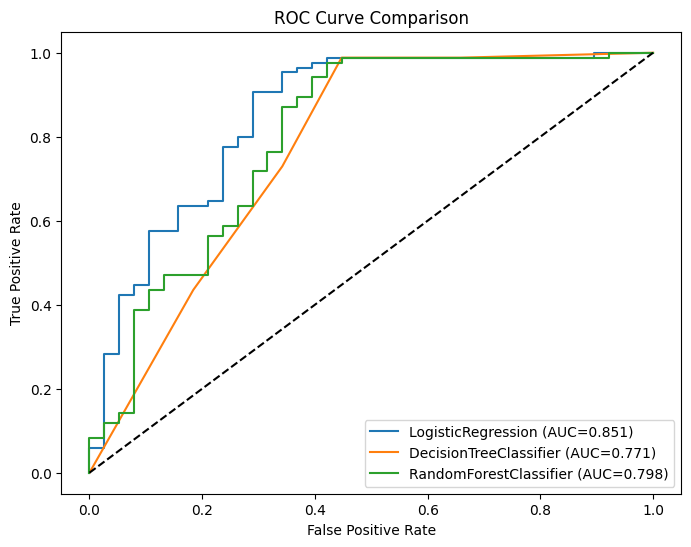

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix, roc_auc_score, roc_curve)

# Load dataset
df = pd.read_csv("Loan_Prediction.csv")

# Fill missing values
for col in df.columns:
    if df[col].dtype == "object":
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].median(), inplace=True)

# Encode categorical variables
df = pd.get_dummies(df, drop_first=True)

# Features & target
X = df.drop("Loan_Status_Y", axis=1)
y = df["Loan_Status_Y"]

# Train-test split with stratification
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Model evaluation function
def evaluate_model(model, xtrain, xtest, ytrain, ytest, plot_roc=True):
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)
    ypred_prob = model.predict_proba(xtest)[:, 1]

    print(f"Model: {model.__class__.__name__}")
    print("Accuracy:", round(accuracy_score(ytest, ypred), 3))
    print("Precision:", round(precision_score(ytest, ypred), 3))
    print("Recall:", round(recall_score(ytest, ypred), 3))
    print("F1 Score:", round(f1_score(ytest, ypred), 3))
    print("ROC-AUC:", round(roc_auc_score(ytest, ypred_prob), 3))
    print(classification_report(ytest, ypred))
    print("Confusion Matrix:\n", confusion_matrix(ytest, ypred))
    print("-" * 50)

    # Plot ROC Curve
    if plot_roc:
        fpr, tpr, _ = roc_curve(ytest, ypred_prob)
        plt.plot(fpr, tpr, label=f"{model.__class__.__name__} (AUC={roc_auc_score(ytest, ypred_prob):.3f})")

# Initialize models
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Hyperparameter tuning - Decision Tree
dt_params = {
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}
dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=5, scoring='f1')
dt_grid.fit(xtrain, ytrain)
best_dt = dt_grid.best_estimator_

# Hyperparameter tuning - Random Forest
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10]
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='f1')
rf_grid.fit(xtrain, ytrain)
best_rf = rf_grid.best_estimator_

# Evaluate all models & plot ROC curves
plt.figure(figsize=(8, 6))
evaluate_model(log_reg, xtrain, xtest, ytrain, ytest)
evaluate_model(best_dt, xtrain, xtest, ytrain, ytest)
evaluate_model(best_rf, xtrain, xtest, ytrain, ytest)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()
